# Lane-Based Data: merge and unstack

This is a demonstration of using python

1. Load and clean a dataset
2. Create a 100 metre segmentation of the road network
3. Merge data against the segmentation
4. Un-stack the data into wide (lane-based) format

## Get our tools installed

For this process you will need `Python 3.9` or later.

We will be useing a custom python package called `segmenter`
The following two cells will check that we have everything installed and ready to go:

In [113]:
# check python version:
# should see output "Python 3.9"
!python --version

Python 3.9.1


In [118]:
# If this cell runs and no errors appear below. we should be good to go.
# Normally takes about 10-20 seconds
# remove the --quiet flags if you are having trouble to see more information as pip tries to do its thing
!pip uninstall segmenter -y --quiet
!pip install https://github.com/thehappycheese/segmenter/archive/refs/tags/v0.1.2.zip --quiet

In [1]:
from segmenter import (
    split_rows_by_category_to_max_segment_length,
    segment_by_categories_and_slk_true_discontinuities,
    fetch_road_network_info
)

import pandas as pd

# Obtain Our Data

In [3]:
# In a future cell we will load up a copy of "IRIS Surface Detail ALL"
# Sadly that dataset does not include Region Number
# so we are going to fetch some extra info from the open data portal


metro_road_network_properties = fetch_road_network_info(
    outFields="NETWORK_TYPE,RA_NO,END_TRUE_DIST,ROAD,END_SLK,START_TRUE_DIST,CWY,START_SLK",
    where="RA_NO=7 and NETWORK_TYPE='State Road'"
)

metro_carriageway_segments = split_rows_by_category_to_max_segment_length(
    data=metro_road_network_properties,
    measure_slk=("START_SLK","END_SLK"),
    measure_true=("START_TRUE_DIST","END_TRUE_DIST"),
    categories=["ROAD","CWY","RA_NO"],
    max_segment_length=99999999,
)
metro_carriageway_segments = metro_carriageway_segments.reset_index()
metro_carriageway_segments["CWY"] = metro_carriageway_segments["CWY"].str[0]
metro_carriageway_segments

...
...
Download Completed. received 3802 records


,ROAD,CWY,RA_NO,segment_index,START_SLK,END_SLK,START_TRUE_DIST,END_TRUE_DIST,NETWORK_TYPE
0,H001,L,07,0,0.00,0.24,0.00,0.24,State Road
1,H001,L,07,1,0.51,0.70,0.51,0.70,State Road
2,H001,L,07,2,1.04,1.43,1.04,1.43,State Road
3,H001,L,07,3,1.37,2.28,1.43,2.34,State Road
4,H001,L,07,4,4.35,4.90,4.41,4.96,State Road
...,...,...,...,...,...,...,...,...,...
640,H941,S,07,640,0.00,0.17,0.00,0.17,State Road
641,H942,S,07,641,0.00,0.05,0.00,0.05,State Road
642,M010,S,07,642,0.00,2.57,0.00,2.57,State Road
643,M026,S,07,643,0.00,12.75,0.00,12.75,State Road


In [2]:
# Here we load a copy of "IRIS Surface Detail ALL" from the file system
# We assume this dataset is the source of truth regarding the start and end and XSP of verly lane in metro.

# The path below may need to be adjusted to the location of the dataset
iris_surface_detail_all = pd.read_csv(
    "./test_data/02.01 - Surface Detail.ALL.2021-07-06.12-51.343776376.csv",
    low_memory=False
)

In [ ]:
# first lets dump everthing that isn't in metro_carriageway_segments
# this can take about 2 minutes because it has to compare the entire 
# metro_carriageway_segments against every row in the
# Surface Detail All looking at SLK overlaps

metro_mask = []
for index, surface_detail_row in iris_surface_detail_all.iterrows():

    chunk = metro_carriageway_segments[
          (surface_detail_row["ROAD_NO"] == metro_carriageway_segments["ROAD"])
        & (surface_detail_row["CWAY"]    == metro_carriageway_segments["CWY"] )
    ]

    mask = (
          (surface_detail_row["SLK_TO"]   >= chunk["START_SLK"])
        & (surface_detail_row["SLK_FROM"] <= chunk["END_SLK"]  )
    )

    if mask.any():
        metro_mask.append(True)
    else:
        metro_mask.append(False)

metro_mask = pd.Series(metro_mask)

metro_mask.value_counts()

In [46]:
# here we drop all rows not in metro
print(f"Length of surface details before {len(iris_surface_detail_all.index)}")
iris_surface_detail_all = iris_surface_detail_all[metro_mask]
print(f"Length of surface details after {len(iris_surface_detail_all.index)}")

Length of surface details before 137648
Length of surface details after 42401


In [47]:
# define a map for columns to rename
surf_cwy_map = {
    "ROAD_NO":            "road_no",
    "CWAY":               "cwy",
    "XSP":                "xsp",
    "SLK_FROM":           "slk_from",
    "SLK_TO":             "slk_to",
    "TRUE_FROM":          "true_from",
    "TRUE_TO":            "true_to",
    "SURF_WIDTH":         "surface_width",
    "SURF_YEAR":          "surface_year",
    "SURF_TYPE":          "surface_type_name",
    "SURF_AGG_SIZE":      "surface_aggregate_size",
    "SURF_ASPHALT_DEPTH": "surface_asphalt_depth",
}

In [52]:
# select rows where POE_TEXT is blank and XSP is NOT blank
iris_surface_detail_all = iris_surface_detail_all[
        iris_surface_detail_all["POE_TEXT"].isna()
    | ~ iris_surface_detail_all["XSP"].isna()
]

# keep only the columns in the left of the map above
iris_surface_detail_all = iris_surface_detail_all[surf_cwy_map.keys()]

# rename remaining columns using the map above
iris_surface_detail_all = iris_surface_detail_all.rename(columns=surf_cwy_map)

# preview the dataframe by writing the variable name iris_surface_detail_all as the last line in this cell
iris_surface_detail_all

,road_no,cwy,xsp,slk_from,slk_to,true_from,true_to,surface_width,surface_year,surface_type_name,surface_aggregate_size,surface_asphalt_depth
0,H001,L,L1,0.00,0.04,0.00,0.04,3.9,2000.0,Asphalt Intersection Mix,NaN,40.0
1,H001,L,L2,0.00,0.04,0.00,0.04,3.3,2000.0,Asphalt Intersection Mix,NaN,40.0
2,H001,L,L1,0.04,0.06,0.04,0.06,5.3,2019.0,Asphalt Dense Graded,NaN,40.0
3,H001,L,L2,0.04,0.06,0.04,0.06,3.9,2000.0,Asphalt Dense Graded,NaN,40.0
4,H001,L,L3,0.04,0.06,0.04,0.06,3.3,2000.0,Asphalt Dense Graded,NaN,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...
137581,H899,S,R,0.11,0.22,0.11,0.22,2.0,2015.0,Asphalt Dense Graded,NaN,90.0
137582,H899,S,L,0.22,0.30,0.22,0.30,1.0,2015.0,Asphalt Dense Graded,NaN,90.0
137583,H899,S,L1,0.22,0.30,0.22,0.30,3.5,2015.0,Asphalt Dense Graded,NaN,90.0
137584,H899,S,L2,0.22,0.30,0.22,0.30,3.5,2015.0,Asphalt Dense Graded,NaN,90.0


<AxesSubplot:>

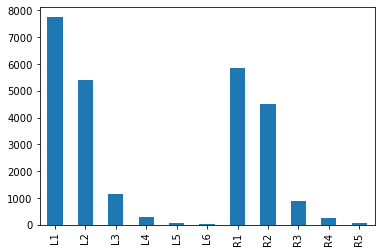

In [53]:
# create a list of XSP values we want to keep
keep_xsp = [
    'L1', 'L2', 'L3', 'L4', 'L5', 'L6',
    'R1', 'R2', 'R3', 'R4', 'R5', 'R6'
]

# discard rows where xsp is not in keep_xsp
iris_surface_detail_all = iris_surface_detail_all[
    iris_surface_detail_all["xsp"].isin(keep_xsp)
]

# check the result
iris_surface_detail_all["xsp"].value_counts().sort_index().plot.bar()

### Obtain a 100 metre Segmentation of the data in long format

- Segments are made at integer multiples of 100 metres
- Segments shorter than 20metres will be combined with adjacent segments
- Other columns are brought along keeping the observation with the longest overlap with the new 100 metre segment

The output produced by this code is suitable for the merge tool

In [55]:
# take a fresh copy of the dataframe
# This line is optional, but suppresses a warning that pandas would otherwise make when we do further processing on a heavily filtered table.
iris_surface_detail_all = iris_surface_detail_all.copy()

# this process typically takes 3 minutes for the entire state road network
# or about 25 seconds for the entire metro network
segmentation = split_rows_by_category_to_max_segment_length(
    iris_surface_detail_all,
    measure_slk        = ("slk_from", "slk_to"),
    measure_true       = ("true_from","true_to"),
    categories         = ["road_no", "cwy", "xsp"],
    max_segment_length = 0.100,
    min_segment_length = 0.020,
)
segmentation

slk_from  slk_to  true_from  true_to  \
road_no cwy xsp segment_index                                         
H001    L   L1  0                  0.00    0.10       0.00     0.10   
                0                  0.10    0.20       0.10     0.20   
                0                  0.20    0.24       0.20     0.24   
                1                  0.51    0.60       0.51     0.60   
                1                  0.60    0.70       0.60     0.70   
...                                 ...     ...        ...      ...   
M045    S   R1  1390              13.30   13.40      13.30    13.40   
                1390              13.40   13.50      13.40    13.50   
                1390              13.50   13.60      13.50    13.60   
                1390              13.60   13.70      13.60    13.70   
                1390              13.70   13.72      13.70    13.72   

                               original_index surface_aggregate_size  \
road_no cwy xsp segment_index                                          
H001    L   L1  0                           0                    NaN   
                0                           9                    NaN   
                0                          11                    NaN   
                1                          34                    NaN   
                1                          34                    NaN   
...                                       ...                    ...   
M045    S   R1  1390                   122210                    NaN   
                1390                   122210                    NaN   
                1390                   122210                    NaN   
                1390                   122210                    NaN   
                1390                   122210                    NaN   

                               surface_width  surface_year  \
road_no cwy xsp segment_index                                
H001    L   L1  0                        3.9        2000.0   
                0                        3.0        2000.0   
                0                        3.0        2000.0   
                1                        3.0        2000.0   
                1                        3.0        2000.0   
...                                      ...           ...   
M045    S   R1  1390                     NaN           NaN   
                1390                     NaN           NaN   
                1390                     NaN           NaN   
                1390                     NaN           NaN   
                1390                     NaN           NaN   

                                      surface_type_name  surface_asphalt_depth  
road_no cwy xsp segment_index                                                   
H001    L   L1  0              Asphalt Intersection Mix                   40.0  
                0                  Asphalt Dense Graded                    NaN  
                0                  Asphalt Dense Graded                    NaN  
                1                  Asphalt Dense Graded                    NaN  
                1                  Asphalt Dense Graded                    NaN  
...                                                 ...                    ...  
M045    S   R1  1390                                NaN                    NaN  
                1390                                NaN                    NaN  
                1390                                NaN                    NaN  
                1390                                NaN                    NaN  
                1390                                NaN                    NaN  

[32967 rows x 10 columns]

In [56]:
segmentation.to_parquet("./test_data/segmentation_state_network.parquet")

In [57]:
# here we take a fresh copy of our segmentation dataframe,
# this way we can edit and re-run this cell many times 
# without accedentally re-manipulating mangled data
seg = segmentation.copy()

# Convert linear measures to integer metres;
# otherwise rounding errors cause strange behaviour when we  call .unstack("xsp").
# Note: We ask pandas to use the type "u4", which is an unsigned 32 bit integer, (can hold positive values up to 2^32 or about 4 Billion)
# pandas will typically use "f8" by default, which is a 64 bit floating point number.
# floating point numbers cause problems with comparisons; For example, the computer considers 0.1 to be exactly equal to 0.1000000000000000055
seg["slk_from"]  = (seg["slk_from"]  * 1000).astype("u4")
seg["slk_to"]    = (seg["slk_to"]    * 1000).astype("u4")
seg["true_from"] = (seg["true_from"] * 1000).astype("u4")
seg["true_to"]   = (seg["true_to"]   * 1000).astype("u4")

# Remove all columns from the hierarchical row index created by the `split_rows_by_category_to_max_segment_length()` function
seg = seg.reset_index()

# Create a new column called "dirn" which will be the first ("zeroth") character of the xsp column (eg. "L1" -> "L")
seg["dirn"] = seg["xsp"].str[0]

# Create a new column called "lane" which will be the second ("oneth") character of the xsp column (eg. "L1" -> "1")
seg["lane"] = seg["xsp"].str[1]

# Optionally drop the xsp column since it is now redundant
seg = seg.drop(columns="xsp")

# Create a new hierarchical row index for the segmentation
# For "unstacking" to be possible the row index must be unique for each row when "lane" is removed from the index
# "carriageway", and "true_to" are optional, but at least ["road_no", "dirn", "true_from", "slk_from", "slk_to", "lane"] are required
seg = seg.set_index(["road_no", "cwy", "dirn", "true_from", "true_to", "slk_from", "slk_to", "lane"])

# preview seg
# note the junk columns:
# - "segment_index" and "original_index" are leftovers from the `split_rows_by_category_to_max_segment_length()` function. They are left in as they are useful for other purposes.
# - All the other columns from the original surface details dataframe are still here (eg surface aggregate size, surface_year etc).
#   We are not really interested in them, lets just ignore them for now.
seg

segment_index  \
road_no cwy dirn true_from true_to slk_from slk_to lane                  
H001    L   L    0         100     0        100    1                 0   
                 100       200     100      200    1                 0   
                 200       240     200      240    1                 0   
                 510       600     510      600    1                 1   
                 600       700     600      700    1                 1   
...                                                                ...   
M045    S   R    13300     13400   13300    13400  1              1390   
                 13400     13500   13400    13500  1              1390   
                 13500     13600   13500    13600  1              1390   
                 13600     13700   13600    13700  1              1390   
                 13700     13720   13700    13720  1              1390   

                                                         original_index  \
road_no cwy dirn true_from true_to slk_from slk_to lane                   
H001    L   L    0         100     0        100    1                  0   
                 100       200     100      200    1                  9   
                 200       240     200      240    1                 11   
                 510       600     510      600    1                 34   
                 600       700     600      700    1                 34   
...                                                                 ...   
M045    S   R    13300     13400   13300    13400  1             122210   
                 13400     13500   13400    13500  1             122210   
                 13500     13600   13500    13600  1             122210   
                 13600     13700   13600    13700  1             122210   
                 13700     13720   13700    13720  1             122210   

                                                        surface_aggregate_size  \
road_no cwy dirn true_from true_to slk_from slk_to lane                          
H001    L   L    0         100     0        100    1                       NaN   
                 100       200     100      200    1                       NaN   
                 200       240     200      240    1                       NaN   
                 510       600     510      600    1                       NaN   
                 600       700     600      700    1                       NaN   
...                                                                        ...   
M045    S   R    13300     13400   13300    13400  1                       NaN   
                 13400     13500   13400    13500  1                       NaN   
                 13500     13600   13500    13600  1                       NaN   
                 13600     13700   13600    13700  1                       NaN   
                 13700     13720   13700    13720  1                       NaN   

                                                         surface_width  \
road_no cwy dirn true_from true_to slk_from slk_to lane                  
H001    L   L    0         100     0        100    1               3.9   
                 100       200     100      200    1               3.0   
                 200       240     200      240    1               3.0   
                 510       600     510      600    1               3.0   
                 600       700     600      700    1               3.0   
...                                                                ...   
M045    S   R    13300     13400   13300    13400  1               NaN   
                 13400     13500   13400    13500  1               NaN   
                 13500     13600   13500    13600  1               NaN   
                 13600     13700   13600    13700  1               NaN   
                 13700     13720   13700    13720  1               NaN   

                                                         surface_year  \
road_no cwy dir

### Ready to Merge

At this point we are ready to merge additional datasets against our segmentation

> TODO:
> 
> Build a merge example.
>
> For now, imagine we added a columns such as `"IRI"` or `"Curv"` or `"Defl"` to the `seg` dataframe previewed above.<br>
> 
> For the following example we will just pretend we are interested in `"surface_width"` and `"surface_year"`

### Ready to Unstack

If we merged additional data columns in the previous step we are ready to unstack our data.
This is a trivial operation in excel with pivot tables, but since we are all set up here in python
lets go ahead with it here:

In [58]:
# select the columns we are "interested" in un-stacking:
seg = seg[["surface_width", "surface_year"]]

#preview seg
seg

surface_width  \
road_no cwy dirn true_from true_to slk_from slk_to lane                  
H001    L   L    0         100     0        100    1               3.9   
                 100       200     100      200    1               3.0   
                 200       240     200      240    1               3.0   
                 510       600     510      600    1               3.0   
                 600       700     600      700    1               3.0   
...                                                                ...   
M045    S   R    13300     13400   13300    13400  1               NaN   
                 13400     13500   13400    13500  1               NaN   
                 13500     13600   13500    13600  1               NaN   
                 13600     13700   13600    13700  1               NaN   
                 13700     13720   13700    13720  1               NaN   

                                                         surface_year  
road_no cwy dirn true_from true_to slk_from slk_to lane                
H001    L   L    0         100     0        100    1           2000.0  
                 100       200     100      200    1           2000.0  
                 200       240     200      240    1           2000.0  
                 510       600     510      600    1           2000.0  
                 600       700     600      700    1           2000.0  
...                                                               ...  
M045    S   R    13300     13400   13300    13400  1              NaN  
                 13400     13500   13400    13500  1              NaN  
                 13500     13600   13500    13600  1              NaN  
                 13600     13700   13600    13700  1              NaN  
                 13700     13720   13700    13720  1              NaN  

[32967 rows x 2 columns]

In [59]:
# .unstack() by "lane"
seg = seg.unstack("lane")

# preview seg
seg

surface_width            \
lane                                                           1    2    3   
road_no cwy dirn true_from true_to slk_from slk_to                           
H001    L   L    0         100     0        100              3.9  3.3  NaN   
                 40        80      40       80               NaN  NaN  3.5   
                 60        80      60       80               NaN  NaN  NaN   
                 100       200     100      200              3.0  3.0  NaN   
                 200       240     200      240              3.0  3.0  NaN   
...                                                          ...  ...  ...   
M045    S   R    13300     13400   13300    13400            NaN  NaN  NaN   
                 13400     13500   13400    13500            NaN  NaN  NaN   
                 13500     13600   13500    13600            NaN  NaN  NaN   
                 13600     13700   13600    13700            NaN  NaN  NaN   
                 13700     13720   13700    13720            NaN  NaN  NaN   

                                                                surface_year  \
lane                                                  4   5   6            1   
road_no cwy dirn true_from true_to slk_from slk_to                             
H001    L   L    0         100     0        100     NaN NaN NaN       2000.0   
                 40        80      40       80      NaN NaN NaN          NaN   
                 60        80      60       80      3.3 NaN NaN          NaN   
                 100       200     100      200     NaN NaN NaN       2000.0   
                 200       240     200      240     NaN NaN NaN       2000.0   
...                                                 ...  ..  ..          ...   
M045    S   R    13300     13400   13300    13400   NaN NaN NaN          NaN   
                 13400     13500   13400    13500   NaN NaN NaN          NaN   
                 13500     13600   13500    13600   NaN NaN NaN          NaN   
                 13600     13700   13600    13700   NaN NaN NaN          NaN   
                 13700     13720   13700    13720   NaN NaN NaN          NaN   

                                                                            \
lane                                                     2       3       4   
road_no cwy dirn true_from true_to slk_from slk_to                           
H001    L   L    0         100     0        100     2000.0     NaN     NaN   
                 40        80      40       80         NaN  2019.0     NaN   
                 60        80      60       80         NaN     NaN  2000.0   
                 100       200     100      200     2000.0     NaN     NaN   
                 200       240     200      240     2000.0     NaN     NaN   
...                                                    ...     ...     ...   
M045    S   R    13300     13400   13300    13400      NaN     NaN     NaN   
                 13400     13500   13400    13500      NaN     NaN     NaN   
                 13500     13600   13500    13600      NaN     NaN     NaN   
                 13600     13700   13600    13700      NaN     NaN     NaN   
                 13700     13720   13700    13720      NaN     NaN     NaN   

                                                            
lane                                                 5   6  
road_no cwy dirn true_from true_to slk_from slk_to          
H001    L   L    0         100     0        100    NaN NaN  
                 40        80      40       80     NaN NaN  
                 60        80      60       80     NaN NaN  
                 100       200     100      200    NaN NaN  
                 200       240     200      240    NaN NaN  
...                                                 ..  ..  
M045    S   R    13300     13400   13300    13400  NaN NaN  
                 13400     13500   13400    13500  NaN NaN  
                 13500     13600   13500    13600  NaN NaN  
            

In [60]:
# do some final clean-up

# remove the hierarchical row index we used in the previous step
# (otherwise we cant sort by "road_number" since it is bound up in the index.)
seg = seg.reset_index()

# Sort things so that our data reads like we are driving down the road
seg = seg.sort_values(by=["road_no", "dirn", "true_from"])

# after the `.unstack()` we need to convert our measures back to kilometers
# this time we will ask for the type "f4", which is a 32 bit floating point number,
# capable of holding positive with about 5 decimal places of accuracy which is enough for any WA SLK
seg["slk_from"]  = seg["slk_from" ].astype("f4") / 1000.0
seg["slk_to"]    = seg["slk_to"   ].astype("f4") / 1000.0
seg["true_from"] = seg["true_from"].astype("f4") / 1000.0
seg["true_to"]   = seg["true_to"  ].astype("f4") / 1000.0

# preview our final output
# (NOTE: `NaN` cells will show up as blank in the output csv)
seg

road_no cwy dirn true_from true_to slk_from slk_to surface_width       \
lane                                                                 1    2   
0        H001   L    L      0.00    0.10     0.00   0.10           3.9  3.3   
1        H001   L    L      0.04    0.08     0.04   0.08           NaN  NaN   
2        H001   L    L      0.06    0.08     0.06   0.08           NaN  NaN   
3        H001   L    L      0.10    0.20     0.10   0.20           3.0  3.0   
4        H001   L    L      0.20    0.24     0.20   0.24           3.0  3.0   
...       ...  ..  ...       ...     ...      ...    ...           ...  ...   
18845    M045   S    R     13.30   13.40    13.30  13.40           NaN  NaN   
18846    M045   S    R     13.40   13.50    13.40  13.50           NaN  NaN   
18847    M045   S    R     13.50   13.60    13.50  13.60           NaN  NaN   
18848    M045   S    R     13.60   13.70    13.60  13.70           NaN  NaN   
18849    M045   S    R     13.70   13.72    13.70  13.72           NaN  NaN   

                        surface_year                                  
lane     3    4   5   6            1       2       3       4   5   6  
0      NaN  NaN NaN NaN       2000.0  2000.0     NaN     NaN NaN NaN  
1      3.5  NaN NaN NaN          NaN     NaN  2019.0     NaN NaN NaN  
2      NaN  3.3 NaN NaN          NaN     NaN     NaN  2000.0 NaN NaN  
3      NaN  NaN NaN NaN       2000.0  2000.0     NaN     NaN NaN NaN  
4      NaN  NaN NaN NaN       2000.0  2000.0     NaN     NaN NaN NaN  
...    ...  ...  ..  ..          ...     ...     ...     ...  ..  ..  
18845  NaN  NaN NaN NaN          NaN     NaN     NaN     NaN NaN NaN  
18846  NaN  NaN NaN NaN          NaN     NaN     NaN     NaN NaN NaN  
18847  NaN  NaN NaN NaN          NaN     NaN     NaN     NaN NaN NaN  
18848  NaN  NaN NaN NaN          NaN     NaN     NaN     NaN NaN NaN  
18849  NaN  NaN NaN NaN          NaN     NaN     NaN     NaN NaN NaN  

[18850 rows x 19 columns]

In [61]:
# Finally, save the result to some file path of your choice:
seg.to_csv("../delme/RES2.csv")